
## Method 1: ARIMA

In [6]:
# Import libraries
import sqlite3 as sql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [7]:
con=sql.connect("./data/paperdb.db")
input_period=90
predication_period=1

In [40]:
SQL_BTC_USD_TRAIN = """
select * from BTC_USD where date>='2019-01-04'  order by date asc
"""
btc_usd = pd.read_sql(SQL_BTC_USD_TRAIN, con)

In [41]:
btc_usd.head()


,date,close,open,high,low,volume,change
0,2019-01-04,3954.9,3923.2,3985.8,3853.3,13.23K,0.81%
1,2019-01-05,3911.0,3954.8,4014.9,3901.4,14.87K,-1.11%
2,2019-01-06,4171.5,3911.0,4214.5,3892.9,25.17K,6.66%
3,2019-01-07,4113.9,4170.9,4196.9,4078.5,11.32K,-1.38%
4,2019-01-08,4100.0,4113.9,4210.0,4056.2,18.72K,-0.34%


In [42]:
btc_usd.Timestamp = pd.to_datetime(btc_usd.date)
# Resampling to daily frequency
btc_usd.index = btc_usd.Timestamp
btc_usd = btc_usd.resample('D').mean()

# # Resampling to monthly frequency
# btc_usd_month = btc_usd.resample('M').mean()

# # Resampling to annual frequency
# btc_usd_year = btc_usd.resample('A-DEC').mean()

# # Resampling to quarterly frequency
# btc_usd_Q = btc_usd.resample('Q-DEC').mean()

In [43]:
btc_usd[btc_usd.index>='2021-01-01'].close

date
2021-01-01    29346.0
2021-01-02    32185.0
2021-01-03    32971.0
2021-01-04    32020.0
2021-01-05    33996.0
               ...   
2021-03-03    50425.0
2021-03-04    48368.0
2021-03-05    48811.0
2021-03-06    48895.0
2021-03-07    50679.0
Freq: D, Name: close, Length: 66, dtype: float64

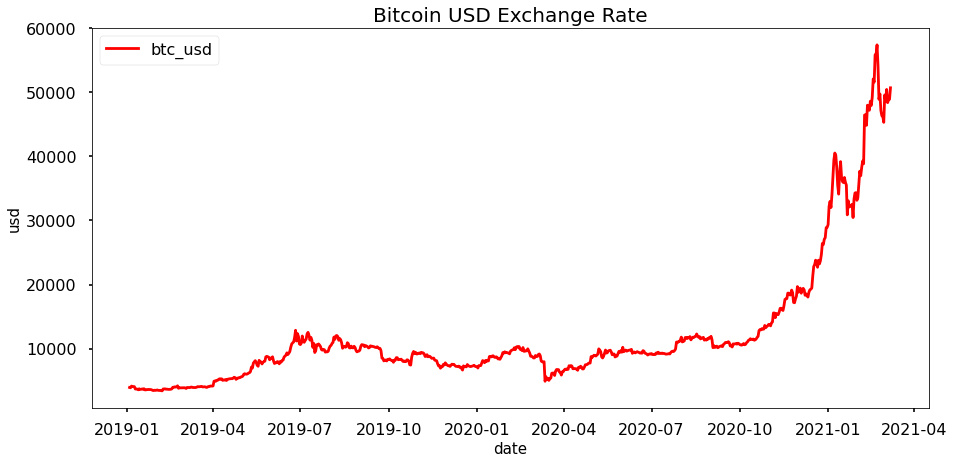

In [44]:
plt.figure(figsize=(15,7))

plt.plot(btc_usd.close, '-r', label='btc_usd')

plt.title("Bitcoin USD Exchange Rate", fontsize=20)
plt.xlabel("date", fontsize=15)
plt.ylabel("usd", fontsize=15)
plt.legend()
plt.show()

*** sm.tsa.stattools.adfuller 用来对做数据的平稳性检测
*** ARIMA模型需要数据是平稳的。如果不平稳的话，需要对数据进行一定的变化，平稳后才能够使用模型
*** 下方模型检验结果为1，说明非常不平稳。 P接近于零则说明可能平稳。

Dickey–Fuller test: p=1.000000


<Figure size 1080x504 with 0 Axes>

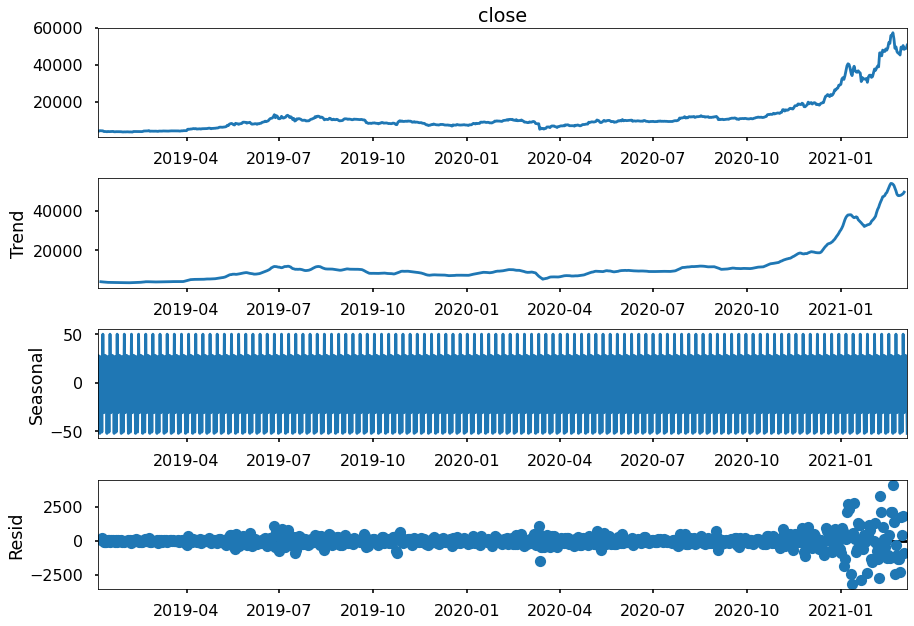

In [45]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(btc_usd.close).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_usd.close)[1])
plt.show()

ADF检验结果 p=1.000000， 说明该时序分布完全不平稳。此时应该使用变换使得数据边平稳


In [46]:
btc_usd['trans_close'], lmbda = stats.boxcox(btc_usd.close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_usd.trans_close)[1])

Dickey–Fuller test: p=0.890227


Dickey–Fuller test: p=0.890227


<Figure size 1080x504 with 0 Axes>

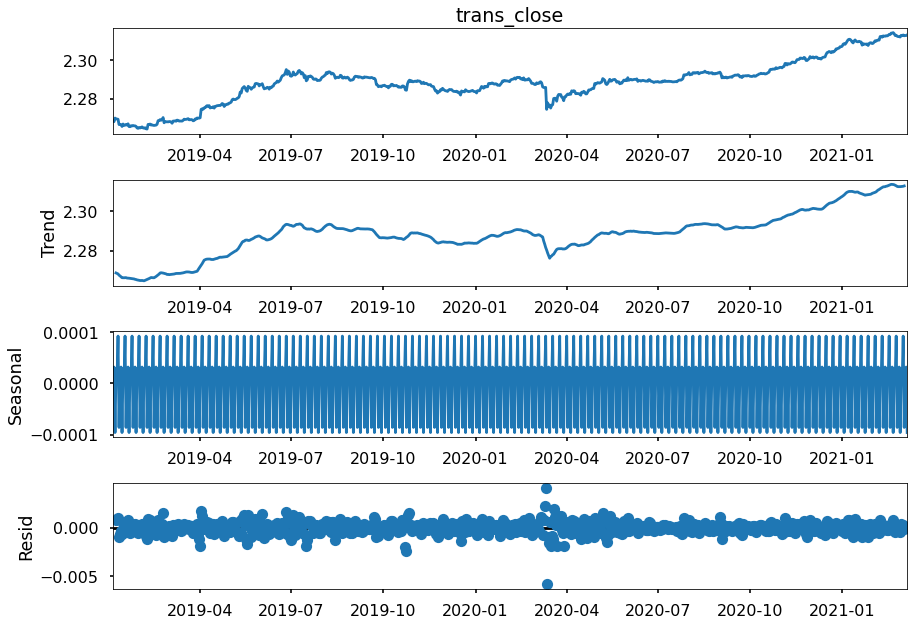

In [47]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(btc_usd.trans_close).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_usd.trans_close)[1])
plt.show()

ADF检验告诉我们结果仍然不平稳。继续变换：

In [48]:
#Seasonal differentiation - 周波动
btc_usd['trans_close_diff'] = btc_usd.trans_close - btc_usd.trans_close.shift(1)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_usd.trans_close_diff[1:])[1])

Dickey–Fuller test: p=0.000000


Dickey–Fuller test: p=0.000000


<Figure size 1080x504 with 0 Axes>

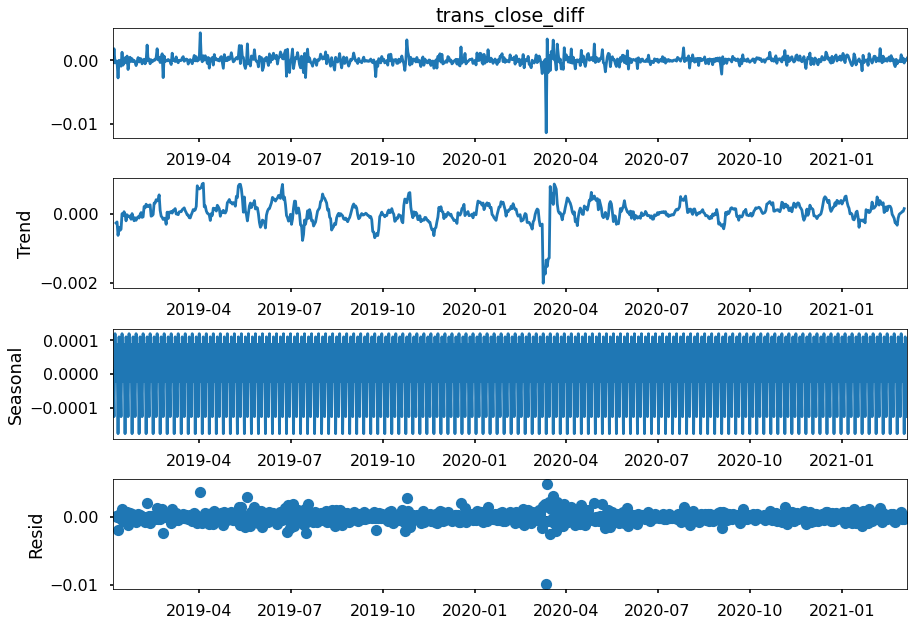

In [49]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(btc_usd.trans_close_diff[1:]).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_usd.trans_close_diff[1:])[1])
plt.show()

现在基本可以认为是平稳的了

In [50]:
# plt.figure(figsize=[15,7])
# sm.tsa.seasonal_decompose(btc_usd.trans_close_diff[7:]).plot()   
# print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_usd.trans_close_diff[7:])[1])
# plt.show()

寻找合适的参数

In [51]:

# len(parameters_list)


In [52]:

# Model Selection; search models/
# Initial approximation of parameters
# def search_model(btc_usd.trans_close):

def search_model(time_serial_data):
#     Qs = range(0, 0)
    qs = range(0, 3)
#     Ps = range(0, 0)
    ps = range(0, 3)
#     D=1
    d=1
    parameters = product(ps, qs)
    parameters_list = list(parameters)
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')
    for param in parameters_list:
        try:
            model=sm.tsa.statespace.SARIMAX(time_serial_data, order=(param[0], d, param[1])).fit(disp=-1)
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
#     print(result_table.sort_values(by = 'aic', ascending=True).head())
#     print(best_model.summary())
    return best_model

In [53]:
# # Best Models
# result_table = pd.DataFrame(results)
# result_table.columns = ['parameters', 'aic']
# print(result_table.sort_values(by = 'aic', ascending=True).head())
# print(best_model.summary())
best_model = search_model(btc_usd.trans_close)

In [54]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [55]:
time_serial_data = btc_usd.close
model = best_model 

In [56]:
time_serial_data.index

DatetimeIndex(['2019-01-04', '2019-01-05', '2019-01-06', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-12', '2019-01-13',
               ...
               '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2021-03-06', '2021-03-07'],
              dtype='datetime64[ns]', name='date', length=794, freq='D')

In [57]:
# invboxcox(best_model.predict(start='2021-03-03', end='2021-03-03'), lmbda)
def predicate_next(model, next_date, lmbda):
    return invboxcox(model.predict(start=next_date, end=next_date), lmbda)

In [58]:
# Prediction
def train_model(time_serial_data):
    '''
    time_serial_data
    '''
    ### iterate below to predicate 30 days. 
    trans_close, lmbda = stats.boxcox(time_serial_data)
    model = search_model(trans_close)
    return model, lmbda
#     predict_result = predicate_next(model,lmbda)

#     btc_usd2 = btc_usd[['trans_close']]
#     # date_list = [datetime(2021, 3, 8), datetime(2021, 3, 9),datetime(2021, 3, 10)
#     #              ,datetime(2021, 3, 11),datetime(2021, 3, 12)]
#     date_list = [datetime(2021, 3, 1), datetime(2021, 3, 2),datetime(2021, 3, 3)
#                  ,datetime(2021, 3, 4),datetime(2021, 3, 5)]
#     future = pd.DataFrame(index=date_list, columns= btc_usd.columns)
#     btc_usd2 = pd.concat([btc_usd2, future])
#     btc_usd2['forecast'] = invboxcox(best_model.predict(start=0, end='2021-03-02'), lmbda)
#     plt.figure(figsize=(15,7))
#     btc_usd.close.plot()
#     btc_usd2.forecast.plot(color='r', ls='--', label='predicted price')
#     plt.legend()
#     plt.title('Bitcoin prices in USD')
#     plt.ylabel('mean USD')
#     plt.show()
#     btc_usd2 = btc_usd[['trans_close']]
#     # date_list = [datetime(2021, 3, 8), datetime(2021, 3, 9),datetime(2021, 3, 10)
#     #              ,datetime(2021, 3, 11),datetime(2021, 3, 12)]
#     date_list = [datetime(2021, 3, 1), datetime(2021, 3, 2),datetime(2021, 3, 3)
#                  ,datetime(2021, 3, 4),datetime(2021, 3, 5)]
#     future = pd.DataFrame(index=date_list, columns= btc_usd.columns)
#     btc_usd2 = pd.concat([btc_usd2, future])
#     btc_usd2['forecast'] = invboxcox(best_model.predict(start=0, end='2021-03-02'), lmbda)
#     plt.figure(figsize=(15,7))
#     btc_usd.close.plot()
#     btc_usd2.forecast.plot(color='r', ls='--', label='predicted price')
#     plt.legend()
#     plt.title('Bitcoin prices in USD')
#     plt.ylabel('mean USD')
#     plt.show()

In [59]:
model.


SyntaxError: invalid syntax (<ipython-input-59-e5c9403477cf>, line 1)

In [60]:
best_model.predict(start=0, end='2021-03-20')

2019-01-04    0.000000
2019-01-05    2.268373
2019-01-06    2.268095
2019-01-07    2.269634
2019-01-08    2.269669
                ...   
2021-03-16    2.313092
2021-03-17    2.313093
2021-03-18    2.313092
2021-03-19    2.313092
2021-03-20    2.313092
Freq: D, Name: predicted_mean, Length: 807, dtype: float64

In [61]:
invboxcox(best_model.predict(start=0, end='2021-03-12'), lmbda)

2019-01-04        1.000000
2019-01-05     3954.900000
2019-01-06     3917.013400
2019-01-07     4133.486583
2019-01-08     4138.517871
                  ...     
2021-03-08    50393.606213
2021-03-09    50560.912893
2021-03-10    50462.572981
2021-03-11    50520.285896
2021-03-12    50486.384950
Freq: D, Name: predicted_mean, Length: 799, dtype: float64

In [62]:
length = len(btc_usd[btc_usd.index<=cur].close)

In [63]:
btc_usd[btc_usd.index<=cur].close[length-1]

49715.0

In [64]:
start_date='2021-01-11'
prdec = []
actual= []
for i in range(45):
    cur = (datetime.datetime.strptime(start_date,'%Y-%m-%d') + datetime.timedelta(days=i)).strftime("%Y-%m-%d")
    cur_next = (datetime.datetime.strptime(start_date,'%Y-%m-%d') + datetime.timedelta(days=i+1)).strftime("%Y-%m-%d")
    length = len(btc_usd[btc_usd.index<=cur].close)
    print(i, cur)
    newModel, lbd = train_model(btc_usd[btc_usd.index<=cur].close)
    acc= btc_usd[btc_usd.index==cur_next].close.values[0]
    prr = invboxcox(newModel.predict(start=length, end=length), lbd)
    actual.append(acc)
    prdec.append(prr[0])
    print(acc, prr[0])

0 2021-01-11
34103.0 35662.95883729065
1 2021-01-12
37375.0 34146.99989837034
2 2021-01-13
39170.0 36994.955410775816
3 2021-01-14
36741.0 39187.05231173536
4 2021-01-15
36055.0 36984.541262912724
5 2021-01-16
35903.0 36009.98904509254
6 2021-01-17
36699.0 35941.185856096585
7 2021-01-18
35958.0 36593.78743948823
8 2021-01-19
35521.1 36087.77400044139
9 2021-01-20
30873.0 35505.349210205735
10 2021-01-21
33062.0 31343.752295854927
11 2021-01-22
32099.0 32555.608270263692
12 2021-01-23
32298.0 32451.85963374553
13 2021-01-24
32268.1 32104.189991358326
14 2021-01-25
32519.0 32366.255716617292
15 2021-01-26
30454.0 32442.173489171713
16 2021-01-27
33331.0 30716.024496985538
17 2021-01-28
34280.7 32838.46018829876
18 2021-01-29
34334.0 34413.04383815934
19 2021-01-30
33141.0 34264.86205576019
20 2021-01-31
33559.0 33309.47242320499
21 2021-02-01
35563.0 33428.394152655455
22 2021-02-02
37677.0 35387.133389039205
23 2021-02-03
36975.0 37513.34788632217
24 2021-02-04
38260.0 37133.8838424527

In [65]:
date_time = datetime.strptime('2021-01-01','%Y-%m-%d')

AttributeError: module 'datetime' has no attribute 'strptime'

In [ ]:
(date_time + datetime.timedelta(days=i)).strftime("%Y-%m-%d")

In [ ]:
invboxcox(newModel.predict(start=753, end=753), lbd)

In [ ]:
len(btc_usd[btc_usd.index<=cur].close)

In [ ]:
def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    mse = skm.mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    error = rmse / len(actual)
   
    print('average RMSE:' , error)
    return error


In [ ]:
def model_plot(actual, predict, name):
    '''
    该函数实现绘制RMSE曲线图
    '''
    plt.figure(figsize=(8,6), dpi=150)
    plt.plot(actual, marker='o', label="actual")
    plt.plot(predict, marker='x', label="predicated")
    plt.grid(linestyle='--', alpha=0.5)
    plt.ylabel(r'$Price$', size=15)
    plt.title('ARIMA Bitcoin Predication Result',  size=18)
    plt.legend()
    plt.show()

In [67]:
evaluate_forecasts(prdec,actual)

average RMSE: 50.20704000650999


50.20704000650999

In [ ]:
import sklearn.metrics as skm
import math

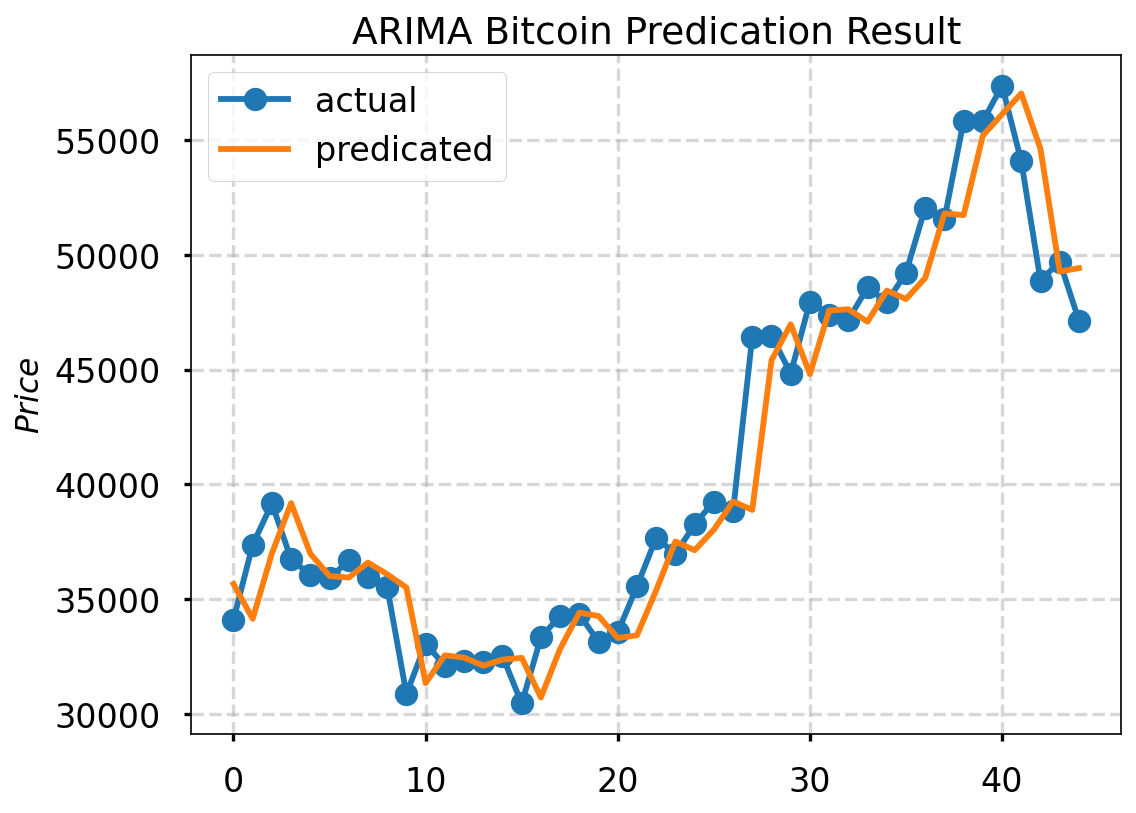

In [66]:
model_plot(actual, prdec, "test")